In [2]:
using KernelDensityEstimate
using Gadfly
using Distributions, StatsBase
using IteratedProbabilisticClassification


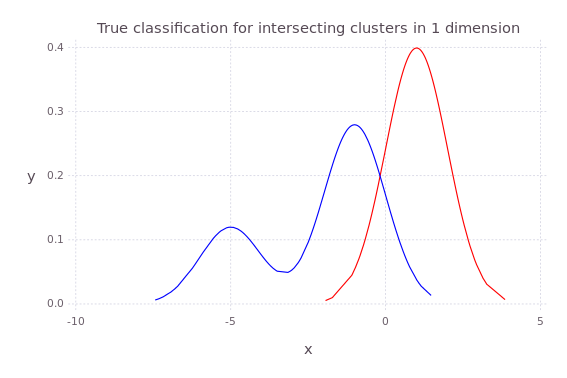

In [12]:
params = TuningParameters(
Mfair=200,   # Cluster distribution approximation accuracy, more is better, computation becomes prohibative beyond ~1000
EMiters=40  # expectation maximization iterations to refine Cluster distribution density estimate and sample classification, diminishing returns beyond ~30
)


# Get simulated data with ground truth for reference
N1, N2 = 5000, 1000
data, groundtruth = simdata01_true(N1=N1,N2=N2)

Gadfly.set_default_plot_size(15cm, 10cm)
# p= plot(x=XX, y=YY, Geom.line) # but we will rather use lower level layers
pl_true = plot(
groundtruth.plt_lyr_cluster[1],
groundtruth.plt_lyr_cluster[2],
# layer(x=data.samples,y=zeros(size(data.samples)),Geom.point,Theme(default_color=colorant"gray")),
Guide.title("True classification for intersecting clusters in 1 dimension"),
)

In [28]:
# initialize prediction at time 
c1_expert = kde!(3.5*randn(params.Mfair)-2.5); # Pretty much a normal distribution
c2_expert = kde!(2.0*randn(params.Mfair)+5.0); # Pretty much a normal distribution
println()

In [22]:
c1_expert = deepcopy(stats.ESTBELIEF[1][end]);
c2_expert = deepcopy(stats.ESTBELIEF[2][end]);
println()

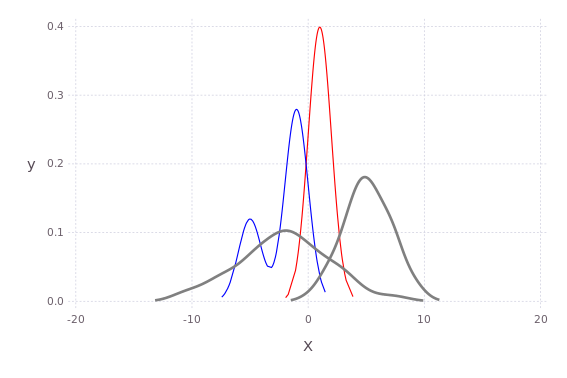

In [29]:
Gadfly.set_default_plot_size(15cm, 10cm)
pl_init = plotKDE([c1_expert,c2_expert],c=["gray";"gray"]);
# lyr_smpls = layer(x=data.samples, y=zeros(size(data.samples)), Geom.point, Theme(default_color=colorant"gray"))
# push!(pl_init.layers, lyr_smpls[1] )
push!(pl_init.layers, groundtruth.plt_lyr_cluster[1])
push!(pl_init.layers, groundtruth.plt_lyr_cluster[2])
pl_init
# Gadfly.draw(PDF("InitialClusterDist.pdf",20cm,12cm),pl_init)
# pl_initnc = plotKDE([c1_expert,c2_expert],c=["blue";"red"]);
# # lyr_smpls = layer(x=data.samples, y=zeros(size(data.samples)), Geom.point, Theme(default_color=colorant"gray"))
# # push!(pl_initnc.layers, lyr_smpls[1] )
# push!(pl_initnc.layers, groundtruth.plt_lyr_cluster_nocolor[1])
# push!(pl_initnc.layers, groundtruth.plt_lyr_cluster_nocolor[2])
pl_init

In [24]:
### [1.0] Classification algorithm part 1 of 2 -- the measurement, generalized expectation maximization (EM) type procedure
c1_meas = deepcopy(c1_expert)
c2_meas = deepcopy(c2_expert)

# [1.1] loop over cluster assignment sample drawing process
dbg = defaultDebugResults()
stats = ClassificationStats()
stats.ESTBELIEF[1] = BallTreeDensity[]
stats.ESTBELIEF[2] = BallTreeDensity[]
stats.POPFRAC = zeros(2,params.EMiters) #Array{Float64,2}()

assigned = zeros(Int, length(data.samples))
prevassigned = rand(Categorical([0.5;0.5]),length(data.samples))
for m in 1:params.EMiters # EM iterations per measurement cycle, this is a tuning parameter -> more iterations should assymptote to true assignment distribution
  # [1.2] numerically approximate a Bayesian prior -- (interpret as Dirichlet sampling process with some implicit concentration parameter)

  #       evaluate the point likelihood of being in each cluster
  c1_likelihoods = evaluateDualTree(c1_meas, data.samples)
  c2_likelihoods = evaluateDualTree(c2_meas, data.samples)

  # [1.3] assign cluster as sampling from categorical distribution
  weights = [c1_likelihoods';c2_likelihoods'];
  assigned = zeros(size(weights,2))
  popFrac = [sum(prevassigned .== 1); sum(prevassigned .== 2)]/(0.0+length(data.samples))
  stats.POPFRAC[:,m] = popFrac'
  for i in 1:size(weights,2)
    p = vec(weights[:,i])
    p = p/sum(p) # renormalize to valid probability distribution
    sel = false ?   rand( Categorical( p ) )   :   round(Int,sdc2(popFrac, p))
    assigned[i] =  sel
  end
  prevassigned = deepcopy(assigned)
  c1_assigned = data.samples[assigned .== 1]
  c2_assigned = data.samples[assigned .== 2]

  push!(dbg.ASSIGNED, assigned)

  # build new intermediate cluster density estimates
  # but subsample to fair chance and practically computable sets first
  len1 = length(c1_assigned)
  len2 = length(c2_assigned)
  c1_assigned_pts = StatsBase.sample(c1_assigned, WeightVec(1.0/len1*ones(len1)), params.Mfair, replace=false)
  c2_assigned_pts = StatsBase.sample(c2_assigned, WeightVec(1.0/len2*ones(len2)), params.Mfair, replace=false)
  c1_meas = kde!(c1_assigned_pts)
  c2_meas = kde!(c2_assigned_pts)
    
    push!(stats.ESTBELIEF[1], deepcopy(c1_meas))
    push!(stats.ESTBELIEF[2], deepcopy(c2_meas)) 

  # visualize what just happened
  pl_meas = plotKDE([c1_meas;c2_meas],c=["blue";"red"]);
  c1_meas_y = evaluateDualTree(c1_meas, c1_assigned)
  c2_meas_y = evaluateDualTree(c2_meas, c2_assigned)
#   push!(pl_meas, layer(x=c1_assigned, y=c1_meas_y, Geom.point, Theme(default_color=colorant"blue"))[1])
#   push!(pl_meas, layer(x=c2_assigned, y=c2_meas_y, Geom.point, Theme(default_color=colorant"red"))[1])
  push!(pl_meas, groundtruth.plt_lyr_cluster[1])
  push!(pl_meas, groundtruth.plt_lyr_cluster[2])
#   push!(pl_meas, layer(x=data.samples, y=zeros(size(data.samples)),Geom.point)[1])
  push!(dbg.PL_MEAS, pl_meas)

  # find the joint distribution using expert biasing, EM measurement iteration (HMM prediction not shown in this example yet)
  c1_meas = c1_meas * c1_expert
  c2_meas = c2_meas * c2_expert

  # measure classification accuracy
  packDebugResults!(dbg, assigned, groundtruth)

end


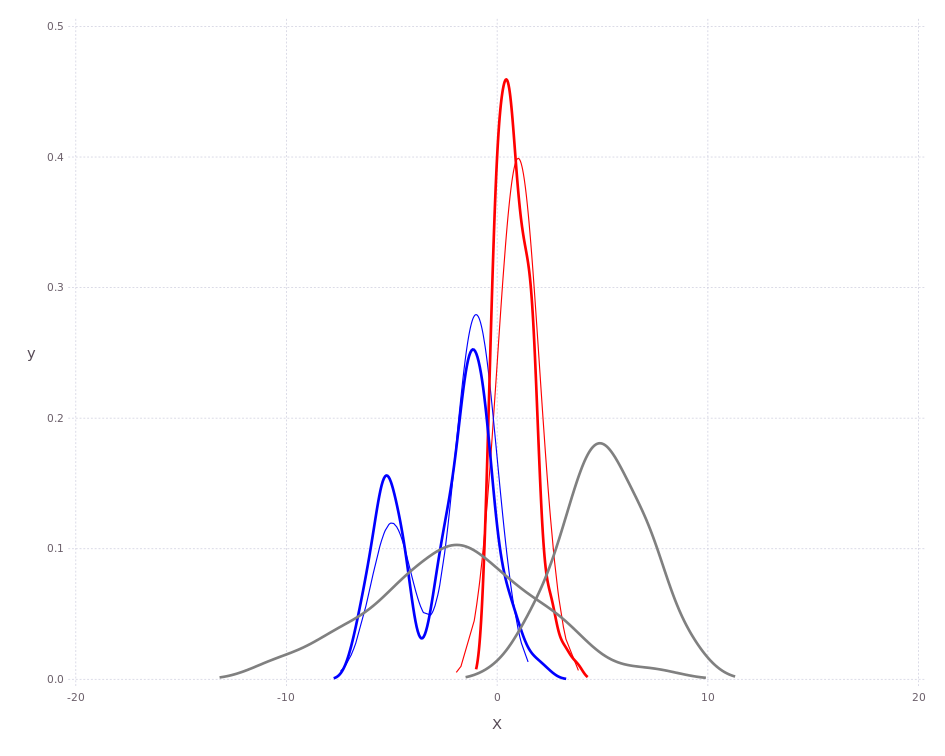

In [30]:
Gadfly.set_default_plot_size(25cm, 20cm)
pl = plotKDE([c1_expert;c2_expert],c=["gray";"gray"])

for l in dbg.PL_MEAS[end].layers
    push!(pl.layers, l)
end
pl

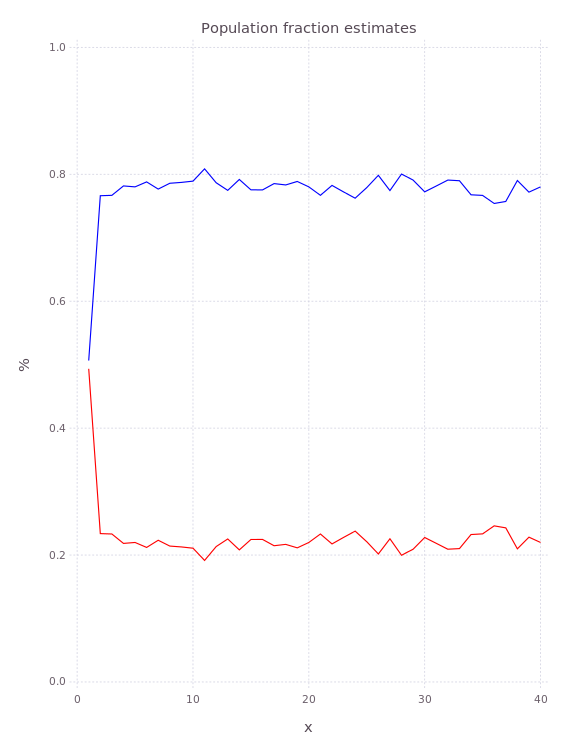

In [26]:
Gadfly.set_default_plot_size(15cm, 20cm)
plotPopulationFraction(params,stats)

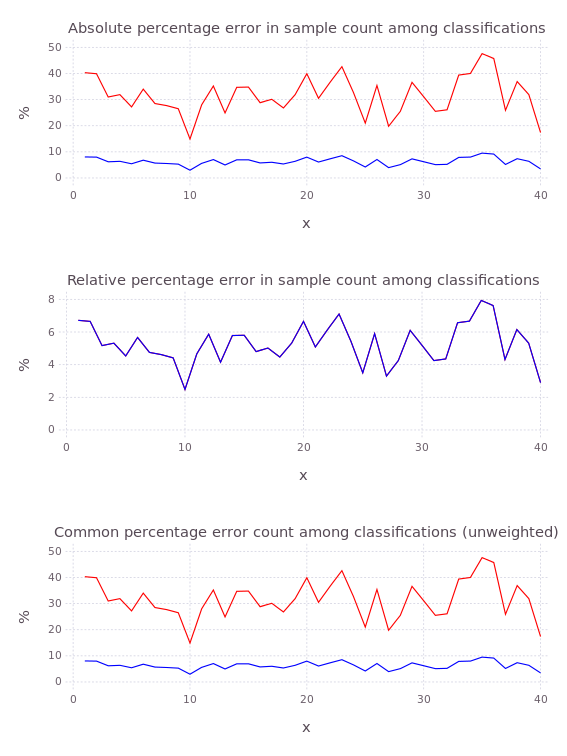

In [27]:
Gadfly.set_default_plot_size(15cm, 20cm)
plotClassificationStats(params, dbg)